# EDA - NoMES


In [2]:
import pandas as pd

changes = pd.read_csv("data_2020.csv", nrows=500000, sep=';')
changes.head()

,id,bikesAvailable,spacesAvailable,allowDropoff,isFloatingBike,state,realTimeData,time,week,yday,day,month,hour,minute,yhour,year
0,649,3,10,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
1,529,36,8,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
2,651,14,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
3,531,2,22,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020
4,532,5,11,1,0,Station on,1,2020/08/02 23:40:03,32,216,3,8,2,"0,666666700",3194,2020


In [147]:
# check for missing values (month, days per month)
# lists months and days per month

# expected values = something


def check_missing_values():

    months = changes['month'].unique()

    for m in months:
        print(m)
        month = changes[changes['month'] == m]
        
        print(month['day'].unique())
        
        # compare to expected values
    # return difference


maxspaces = max(changes["bikesAvailable"])

print(changes[changes["bikesAvailable"] == maxspaces])

check_missing_values()

id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
325932  11             106                0             1               0   

             state  realTimeData                 time  week  yday  day  month  \
325932  Station on             1  2020/08/05 11:55:02    32   218    5      8   

        hour       minute  yhour  year  
325932    14  0,916666700   3254  2020  
8
[3 4 5 6]


In [148]:
# separate stations in their own dataframes

telling_ids = changes['id'].unique()
stations = {}

for i in telling_ids:
    station = changes[changes['id'] == i]
    stations[i] = station

print(len(stations))
print(stations[11])

450
        id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
132     11              37                6             1               0   
582     11              37                6             1               0   
1032    11              38                6             1               0   
1482    11              38                6             1               0   
1932    11              38                6             1               0   
...     ..             ...              ...           ...             ...   
497832  11              68                5             1               0   
498282  11              66                6             1               0   
498732  11              66                6             1               0   
499182  11              68                4             1               0   
499632  11              68                4             1               0   

             state  realTimeData                 time  week  yday  day 

In [149]:
# map station names to ids
# clean station names

def clean_names(names):
    # strip and removal of duplicates
    return set([name.strip() for name in names])


station_data = pd.read_csv("tellingit_2017-2021.csv", sep=';')
station_names = station_data[station_data['year'] == 2020]['name'].unique()
station_names = clean_names(station_names)
station_ids = station_data[station_data['year'] == 2020]['id'].unique()

names_ids = {}

for ids in station_ids:
    name = station_data[station_data['id'] == ids].iloc[0]['name']
    names_ids[ids] = name


print(names_ids[11])

Unioninkatu


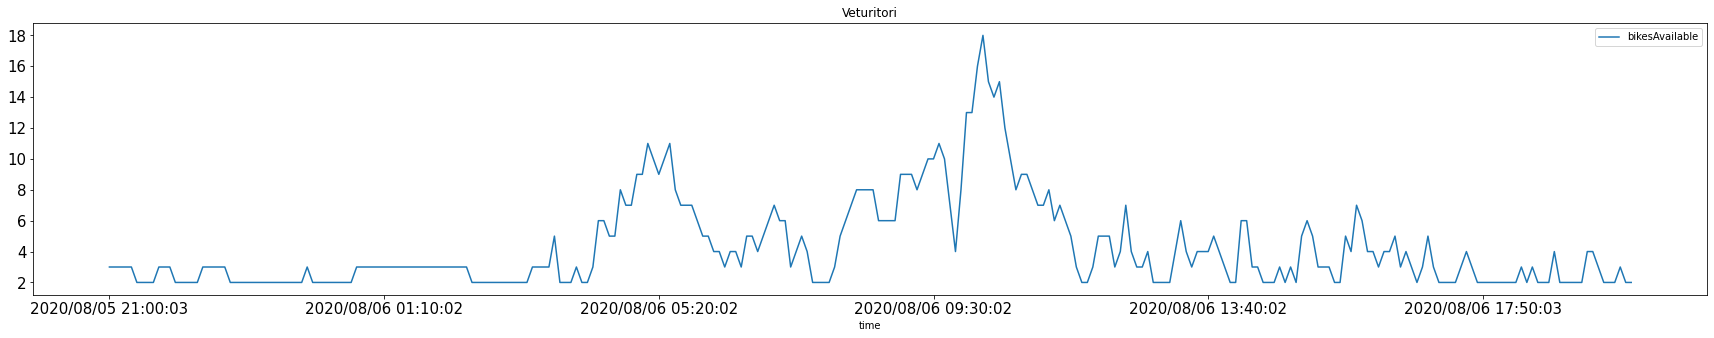

In [194]:
# plot changes per station over time X

import matplotlib.pyplot as plt

def filter_rows(yday: int, station_id: int, min_hour: int, max_hour: int) -> pd.DataFrame():
    yday = yday
    i = station_id
    station = stations[i]

    station = station[station['yday'] == yday]

    if min_hour is not None and max_hour is not None:
        station = station[(station['yhour'] >= min_hour) & (station['yhour'] <= max_hour)]

    return station


def plot_bike_changes(station_id, station):
    station.plot(x='time', y='bikesAvailable', figsize=(30,5), fontsize=15, title=names_ids[station_id])

i = 113
station = filter_rows(219, i, None, None)
plot_bike_changes(i, station)


(23, 2)


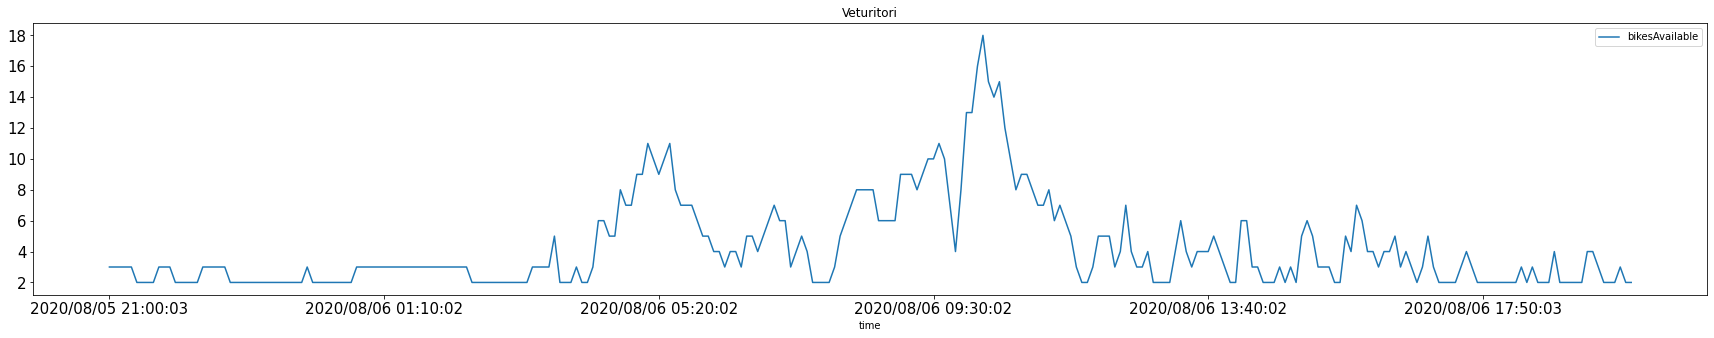

In [195]:
# count how many times per day bikes drop to day's minimum

def count_drops(station):
    minbikes = min(station['bikesAvailable'])
    counts = 0
    was_min = False

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # drop starts
        if not was_min and bikes == minbikes:
            counts += 1
            was_min = True

        # drop ends
        elif was_min and bikes != minbikes:
            was_min = False

    return counts, minbikes

i = 113
station = filter_rows(219, i, None, None)
print(count_drops(station))
plot_bike_changes(i, station)

changes 124


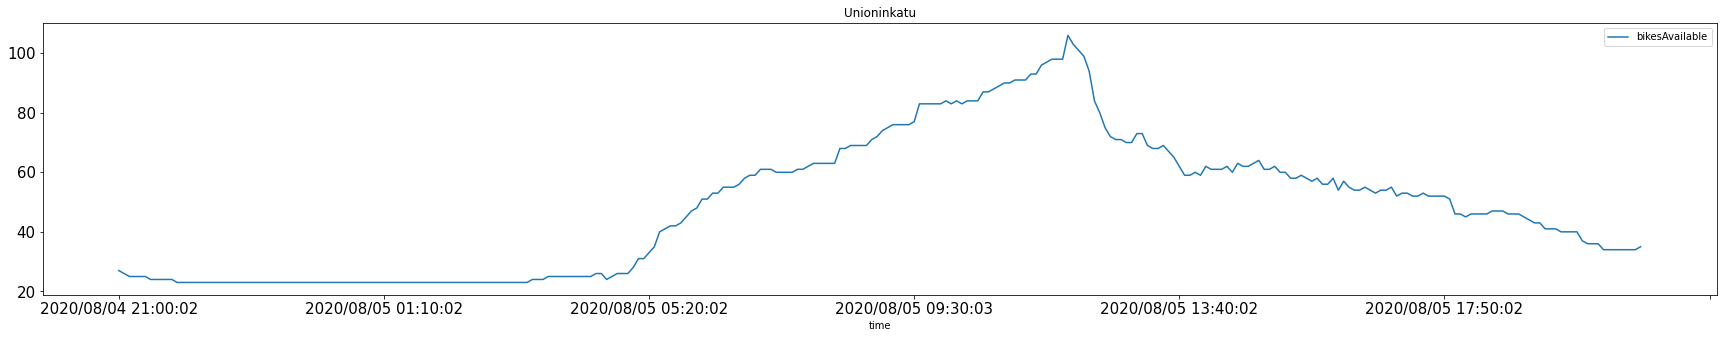

In [196]:
# Count the number of changes
# there is a change if the number of bikes is different than for the previous 5min (doesn't take into account the number of bikes changed)

def count_changes(station):
    counts = 0
    previous = -1

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # print(previous, bikes)
        if bikes != previous:
            # found change 
            counts += 1
            previous = bikes

        # print(counts)
    return counts

i = 11
station = filter_rows(218, i, None, None)
print("changes", count_changes(station))
plot_bike_changes(i, station)